In [160]:
def EWT_beta(x):
    # function used in the construction of Meyer's wavelet
    if x < 0:
        bm = 0
    elif x > 1:
        bm = 1
    else:
        bm = x**4 * (35 - 84*x + 70*x**2 - 20*x**3)

    return bm

In [161]:
def EWT_Meyer_Scaling(w1, gamma, N):
    # Generate the 1D Meyer wavelet in the Fourier
    # domain associated to the segment [0, w1]
    # with transition ratio gamma

    Mi = int(np.floor(N/2))
    w = np.fft.fftshift(np.arange(0, 2*np.pi, 2*np.pi/N))
    w[:Mi] -= 2*np.pi

    aw = np.abs(w)
    yms = np.zeros(N)

    an = 1 / (2 * gamma * w1)
    pbn = (1 + gamma) * w1
    mbn = (1 - gamma) * w1

    for k in range(N):
        if aw[k] <= mbn:
            yms[k] = 1
        elif mbn <= aw[k] <= pbn:
            yms[k] = np.cos(np.pi * EWT_beta(an * (aw[k] - mbn)) / 2)

    yms = np.fft.ifftshift(yms)

    return yms


In [162]:
def EWT_Meyer_Wavelet(wn, wm, gamma, N):
    # Generate the 1D Meyer wavelet in the Fourier
    # domain associated to scale segment [wn, wm]
    # with transition ratio gamma

    Mi = int(np.floor(N/2))
    w = np.fft.fftshift(np.arange(0, 2*np.pi, 2*np.pi/N))
    w[:Mi] -= 2*np.pi

    aw = np.abs(w)
    ymw = np.zeros(N)

    an = 1 / (2 * gamma * wn)
    am = 1 / (2 * gamma * wm)
    pbn = (1 + gamma) * wn
    mbn = (1 - gamma) * wn
    pbm = (1 + gamma) * wm
    mbm = (1 - gamma) * wm

    for k in range(N):
        if pbn <= aw[k] <= mbm:
            ymw[k] = 1
        elif mbm <= aw[k] <= pbm:
            ymw[k] = np.cos(np.pi * EWT_beta(am * (aw[k] - mbm)) / 2)
        elif mbn <= aw[k] <= pbn:
            ymw[k] = np.sin(np.pi * EWT_beta(an * (aw[k] - mbn)) / 2)

    ymw = np.fft.ifftshift(ymw)

    return ymw

In [163]:
def EWT_Meyer_FilterBank(boundaries, N):
    # Generate the filter bank (scaling function + wavelets)
    # corresponding to the provided set of frequency segments

    Npic = len(boundaries)

    # Compute gamma accordingly to the theory
    gamma = 1
    for k in range(Npic - 1):
        r = (boundaries[k + 1] - boundaries[k]) / (boundaries[k + 1] + boundaries[k])
        if r < gamma:
            gamma = r

    r = (np.pi - boundaries[Npic - 1]) / (np.pi + boundaries[Npic - 1])
    if r < gamma:
        gamma = r
    gamma = (1 - 1 / N) * gamma  # This ensures that gamma is chosen as strictly less than the min

    mfb = [None] * (Npic + 1)

    # Start by generating the scaling function
    mfb[0] = EWT_Meyer_Scaling(boundaries[0], gamma, N)

    # Generate the wavelets
    for k in range(Npic - 1):
        mfb[k + 1] = EWT_Meyer_Wavelet(boundaries[k], boundaries[k + 1], gamma, N)

    mfb[Npic] = EWT_Meyer_Wavelet(boundaries[Npic - 1], np.pi, gamma, N)

    return mfb

In [164]:
import matplotlib.pyplot as plt
import numpy as np

In [165]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.io import loadmat
import scipy.io as sio

In [167]:
mat_data = sio.loadmat('/content/drive/MyDrive/signalfile/ecg_signal.mat')
zf = mat_data['ecg_signal'].flatten()
Fs = 500

<ipython-input-161-8a087b1dd2c1>:13: RuntimeWarning: divide by zero encountered in double_scalars
  an = 1 / (2 * gamma * w1)
<ipython-input-162-2a3777d38d29>:14: RuntimeWarning: divide by zero encountered in double_scalars
  am = 1 / (2 * gamma * wm)


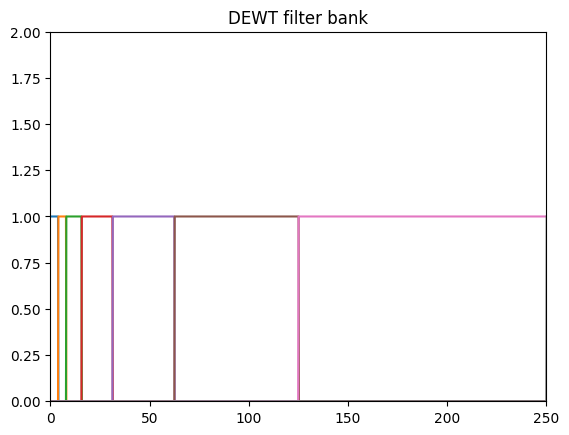

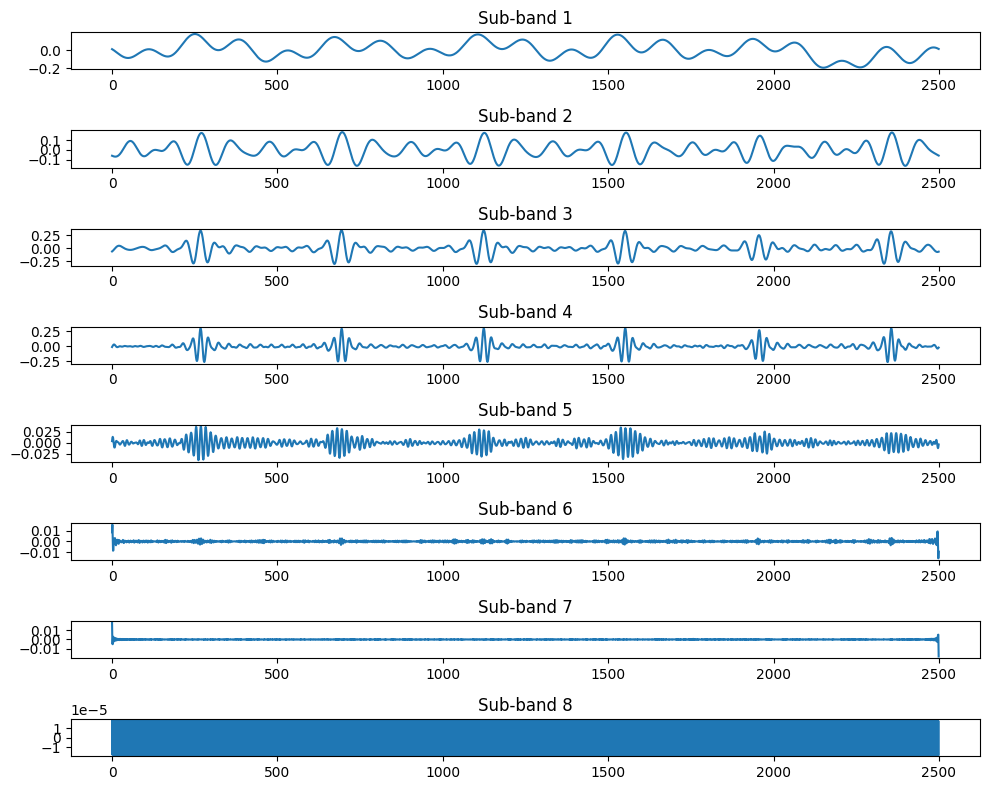

In [168]:
f = zf
pp = np.max(np.abs(f))
f = f / pp
x1 = f
N = len(f)
params_SamplingRate = Fs
L = 7  # Decomposition level
frequency = (Fs / 2.**(np.arange(L, 0, -1)))  # Dyadic frequency grid
subresf = 1
boundaries = (frequency * (2 * np.pi)) / Fs  # Boundary evaluation from frequency
ff = np.fft.fft(f)

# Build the corresponding filter bank
mfb = EWT_Meyer_FilterBank(boundaries, len(ff))

# Filter the signal to extract each subband
ewt = [np.real(np.fft.ifft(np.conj(mfbk) * ff)) for mfbk in mfb]

# Plot the filter bank
plt.figure()
Bound = 1
xxx = np.linspace(0, 1, len(mfb[0])) * Fs
for i in range(len(mfb)):
    plt.plot(xxx, mfb[i])
plt.xlim([0, round(Fs/2)])
plt.ylim([0, 2])
plt.title('DEWT filter bank')

# Plot the sub-bands
plt.figure(figsize=(10, 8))
for i in range(L + 1):
    plt.subplot(L + 1, 1, i + 1)
    plt.plot(ewt[i])
    plt.title(f'Sub-band {i + 1}')

plt.tight_layout()
plt.show()
